In [1]:
import pandas as pd
import os
import glob
import re

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [2]:
# Creación del dataframe

path = os.getcwd()
csv_files = glob.glob(os.path.join("./", "dataset/*.csv"))
#print(csv_files)

dataset = pd.DataFrame()

for f in csv_files:
    brand = re.sub(r'\.\/dataset\\', "", f)
    brand = brand.replace(".csv", "")
    
    df = pd.read_csv(f)
    df["brand"] = brand
    
    tax_c = [x for x in df.columns if re.match(r'tax', x)]
    
    if "tax" not in tax_c and tax_c != []:
        tax_c_str = tax_c[0]
        df.rename(columns = {tax_c_str : 'tax'}, inplace = True)
    
    dataset = dataset.append(df)

9756.221876705986


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


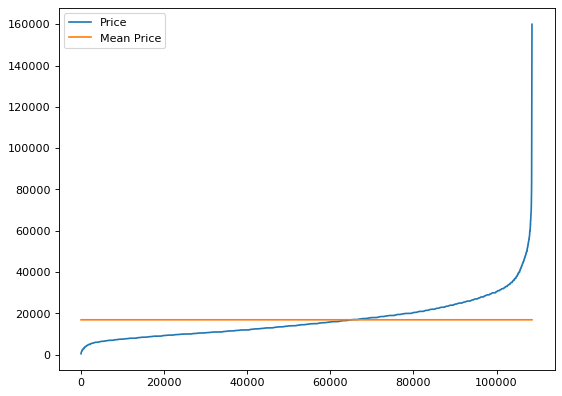

In [3]:
# Error Base

from sklearn.metrics import mean_squared_error

y_base = dataset['price'].mean()

print(mean_squared_error(dataset['price'], [y_base]*dataset.shape[0], squared = False))

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

price = ax.plot(sorted(dataset['price'].to_numpy()), label = "Price")
mean_price = ax.plot([y_base]*dataset.shape[0], label = "Mean Price")
ax.legend()

plt.show()

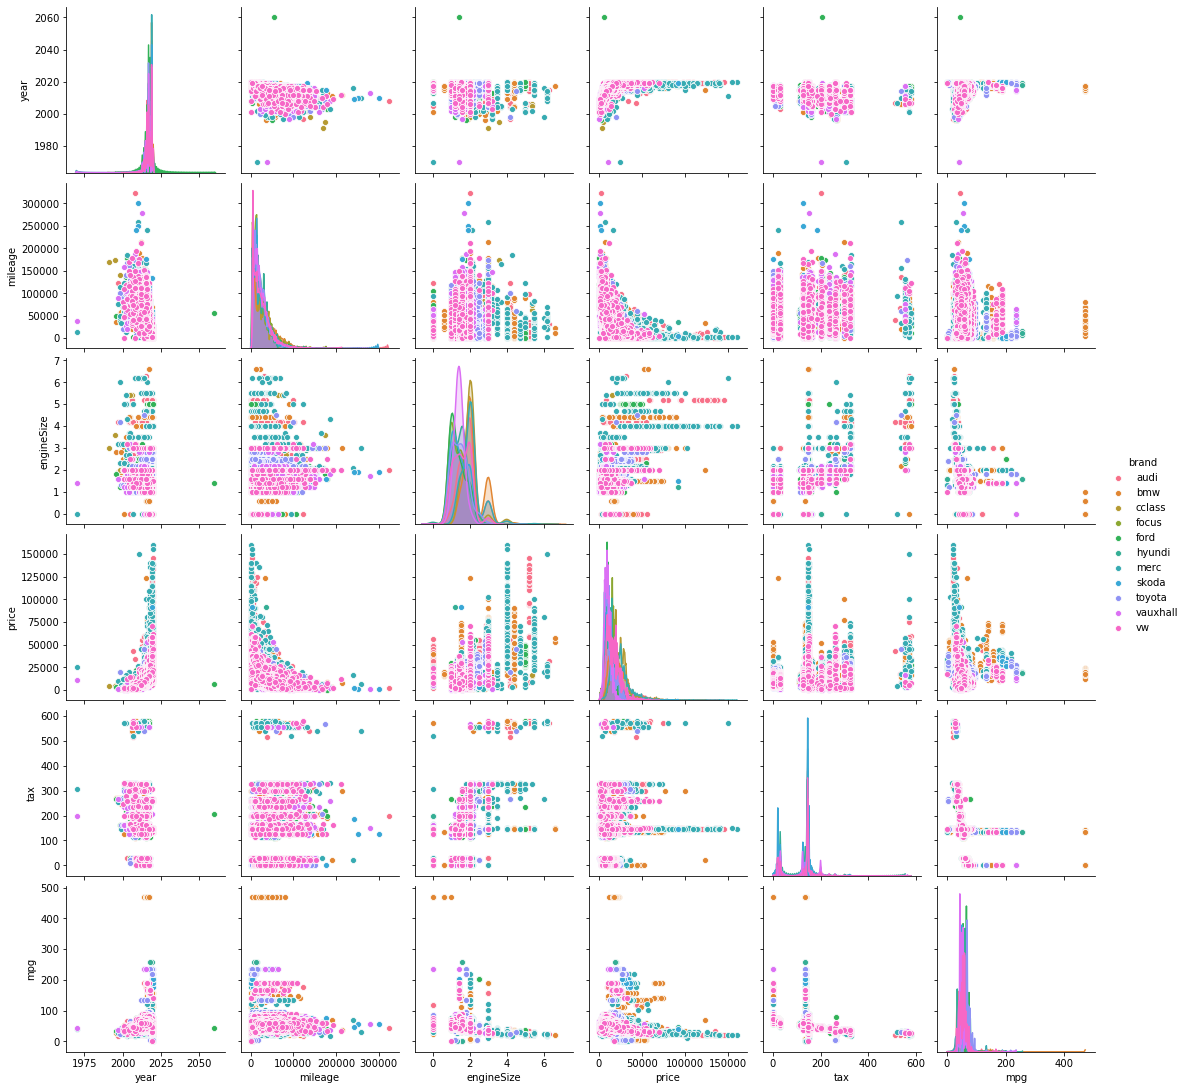

In [4]:
sns.pairplot(dataset[['year', 'mileage', 'engineSize', 'price', 'tax', 'mpg', 'brand']], hue='brand', diag_kws={'bw': 0.2})

In [5]:
dataset = dataset.drop(columns = "tax")    
dataset['mpg'].fillna(dataset['mpg'].mean(), inplace = True)

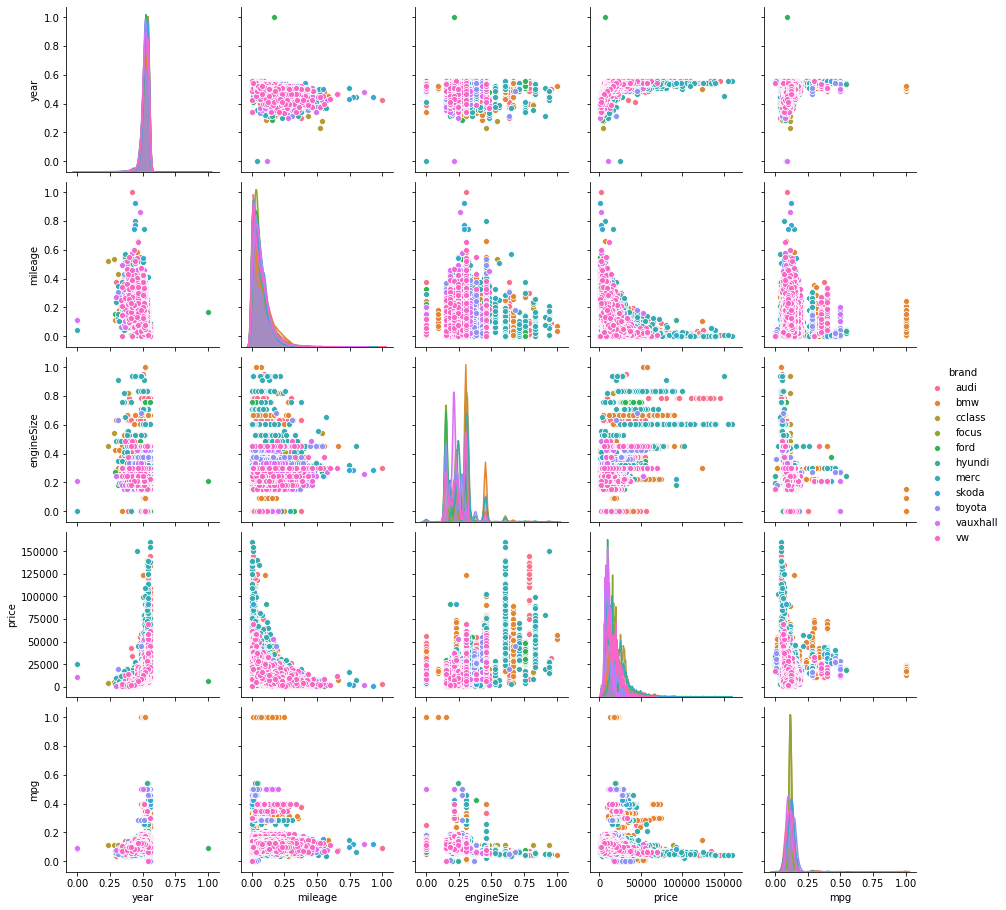

In [6]:
# Preprocesamiento de datos
scaler = preprocessing.MinMaxScaler()
label_enc = preprocessing.LabelEncoder()

# Datos a regularizar
reg_data = ['year', 'mileage', 'engineSize', 'mpg']

# Datos a etiquetar
#lab_data = ['model', 'transmission', 'fuelType', 'brand']

dataset = dataset.drop(columns = 'model')
lab_data = ['transmission', 'fuelType', 'brand']

dataset[reg_data] = scaler.fit_transform(dataset[reg_data])

for c in lab_data:
    #dataset[c] = label_enc.fit_transform(dataset[c])

    ohe_df = pd.get_dummies(dataset[c], prefix = c)
    dataset = pd.concat([dataset, ohe_df], axis=1)
    if c != 'brand':        
        dataset = dataset.drop(columns = c)  

sns.pairplot(dataset[['year', 'mileage', 'engineSize', 'price', 'mpg', 'brand']], hue='brand', diag_kws={'bw': 0.01})
dataset = dataset.drop(columns = 'brand')
        
dataset = dataset.sample(frac = 1, random_state = 4815)

In [7]:
def outlier_remove(dataset):
    
    cols = ["price", "mileage", "year"]
    quantile_p_max=dataset.quantile(0.98)
    quantile_p_min=dataset.quantile(0.02)
    
    quantile_m_max=dataset.quantile(0.97)
    quantile_m_min=dataset.quantile(0.02)
    
    quantile_y_max=dataset.quantile(0.97)
    quantile_y_min=dataset.quantile(0.02)
        
    #dataset = dataset[dataset['price'] < quantile_p_max['price']]
    #dataset = dataset[dataset['price'] > quantile_p_min['price']]
    
    #dataset = dataset[dataset["mileage"] < quantile_m_max["mileage"]]
    #dataset = dataset[dataset["mileage"] > quantile_m_min["mileage"]]
    
    #dataset = dataset[dataset["year"] < quantile_y_max["year"]]
    #dataset = dataset[dataset["year"] > quantile_y_min["year"]]
     
    dataset = dataset[(dataset["year"] != 2060) & (dataset["year"] != 1970)]
    dataset = dataset[dataset["engineSize"] != 0]
    return dataset

In [8]:
kf = KFold(n_splits = 5,  shuffle=True, random_state=4815)
kf.get_n_splits(dataset)
t = kf.split(dataset)
splits_dataset = []
for i in t:
    splits_dataset.append([outlier_remove(dataset.iloc[i[0]]), dataset.iloc[i[1]]]) # Creamos una lista de 5 listas divididas en las distintas partes de train y test (5,2)

RMSE: 4848.015245264378
4341


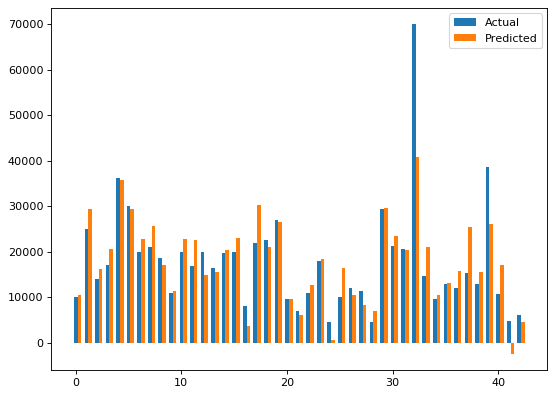

RMSE: 4770.730805988537
4341


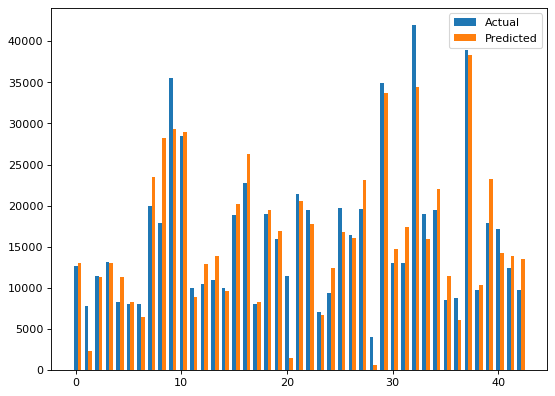

RMSE: 4578.779790531559
4341


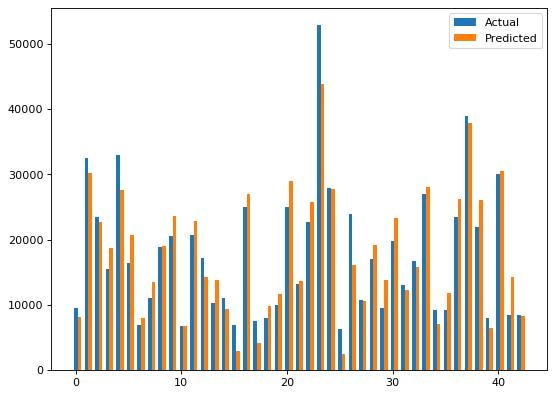

RMSE: 4633.61533730053
4341


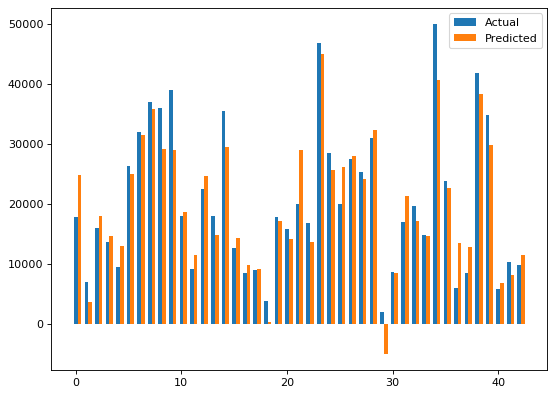

RMSE: 4769.53169597715
4341


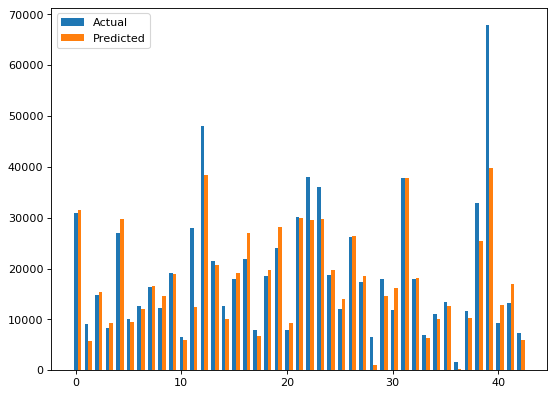

In [9]:
# Regresión lineal

lin_reg = LinearRegression()

for dataset_train, dataset_test in splits_dataset:
    #print("\nTRAIN: [", train_index[0], " ... ", train_index[-1], "", "TEST:", test_index)
    
    y_train = dataset_train['price']
    y_test = dataset_test['price']
    X_train = dataset_train.drop(columns = 'price')
    X_test = dataset_test.drop(columns = 'price')
  
    lin_reg.fit(X_train, y_train)
    
    y_pred = lin_reg.predict(X_test)
    
    print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    
    print(int(y_test.shape[0] * 0.2))
    y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
    y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]
    
    bar_width = 0.35
    index = np.arange(0, y_test_plot.shape[0])
    actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
    pred = ax.bar(index + bar_width, y_pred_plot, width = bar_width, label = "Predicted")
    ax.legend()
    
    plt.show()

In [12]:
# Random Tree Regressor

parameters = {
    'n_estimators' : np.arange(100, 500, 10),
    'criterion' : ('mse', 'mae'),    
}

rnd_forest_reg = RandomForestRegressor()
rs = RandomizedSearchCV(rnd_forest_reg, parameters, n_iter = 25, verbose = 1, n_jobs = -1, cv = 3, random_state = 4815)

X_hyper = dataset.drop(columns = 'price')
y_hyper = dataset['price']

X_hyper = X_hyper.drop(X_hyper.tail(int(X_hyper.shape[0]*0.35)).index)
y_hyper = y_hyper.drop(y_hyper.tail(int(y_hyper.shape[0]*0.35)).index)

search = rs.fit(X_hyper, y_hyper)
best_params = search.best_params_

print(best_params)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 33.8min finished


{'n_estimators': 140, 'criterion': 'mae'}


(6651, 24)
(6651,)
RMSE: 3412.873476189066
4341


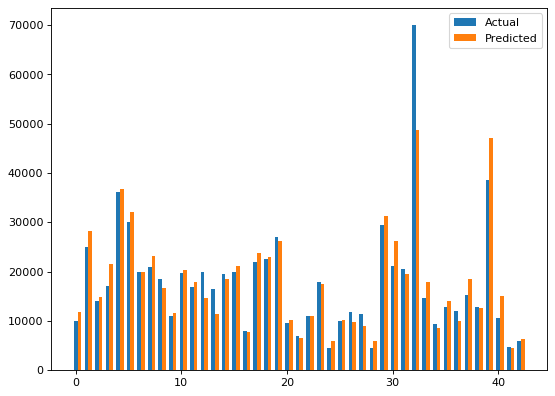

(6742, 24)
(6742,)
RMSE: 3498.148213281114
4341


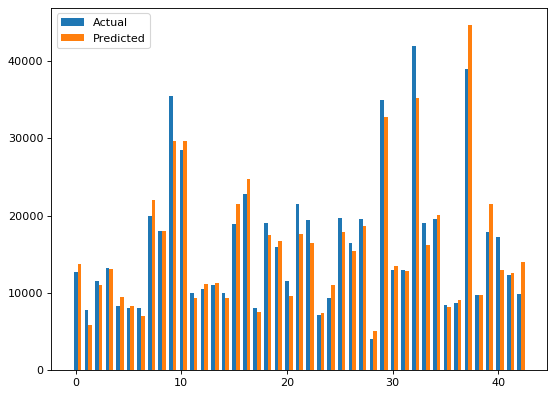

(6752, 24)
(6752,)
RMSE: 3303.802051075269
4341


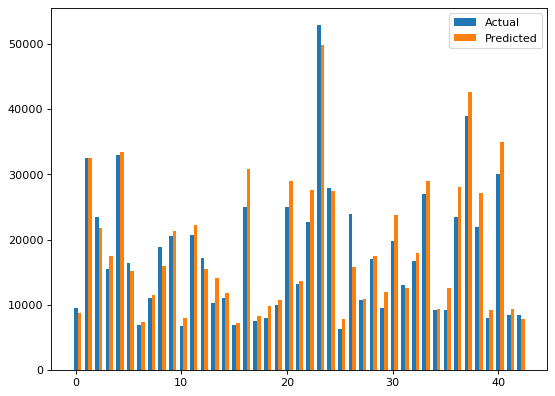

(6701, 24)
(6701,)
RMSE: 3391.405750326066
4341


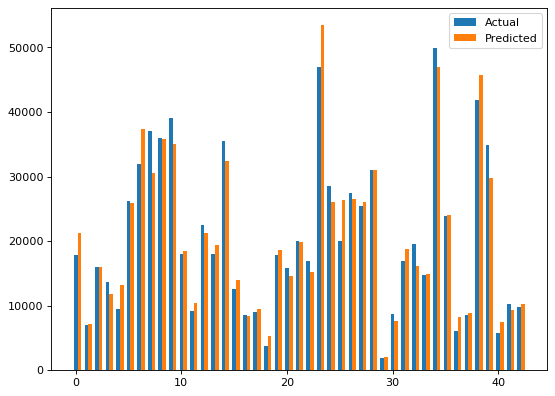

(6646, 24)
(6646,)
RMSE: 3690.8666697459535
4341


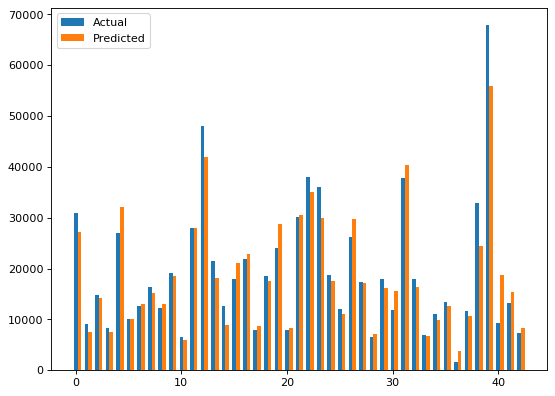

In [14]:
best_params = {'n_estimators': 140, 'criterion': 'mae'}

for dataset_train, dataset_test in splits_dataset:
    #print("\nTRAIN: [", train_index[0], " ... ", train_index[-1], "", "TEST:", test_index)
    
    y_train = dataset_train['price']
    y_test = dataset_test['price']
    X_train = dataset_train.drop(columns = 'price')
    X_test = dataset_test.drop(columns = 'price')
    
    X_train = X_train.drop(X_train.tail(int(X_train.shape[0]*0.4)).index)
    y_train = y_train.drop(y_train.tail(int(y_train.shape[0]*0.4)).index)
    
    print(X_train.shape)
    print(y_train.shape)
    
    rnd_forest_reg.set_params(**best_params)
    rnd_forest_reg.fit(X_train, y_train)
    
    y_pred = rnd_forest_reg.predict(X_test)
    
    print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

    print(int(y_test.shape[0] * 0.2))
    y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
    y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]

    bar_width = 0.35
    index = np.arange(0, y_test_plot.shape[0])
    actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
    pred = ax.bar(index + bar_width, y_pred_plot, width = bar_width, label = "Predicted")
    ax.legend()

    plt.show()

In [15]:
import xgboost as xgb

In [16]:
params = {
'n_estimators': [400, 1000],
'max_depth': [15, 25],
'reg_alpha': [1.1, 1.3],
'reg_lambda': [1.1, 1.3],
}

arboles = xgb.XGBRegressor(verbosity=1)

rs = RandomizedSearchCV(
estimator=arboles,
param_distributions=params,
n_jobs=-1,
cv = 2,
n_iter = 5,
verbose = 1
)

In [17]:
X_hyper = dataset.drop(columns = 'price')
y_hyper = dataset['price']

X_hyper = X_hyper.drop(X_hyper.tail(int(X_hyper.shape[0]*0.35)).index)
y_hyper = y_hyper.drop(y_hyper.tail(int(y_hyper.shape[0]*0.35)).index)

search = rs.fit(X_hyper, y_hyper)
best_params = search.best_params_

print("Mejores parámetros encontrados:")
print(best_params)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.7s finished


Mejores parámetros encontrados:
{'reg_lambda': 1.1, 'reg_alpha': 1.1, 'n_estimators': 400, 'max_depth': 15}


RMSE: 2409.204647838453
4341


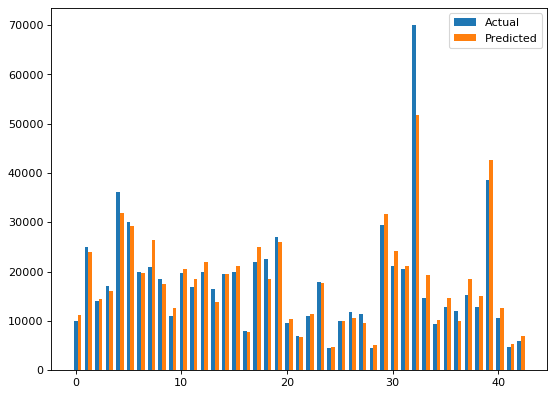

RMSE: 2475.0576080448914
4341


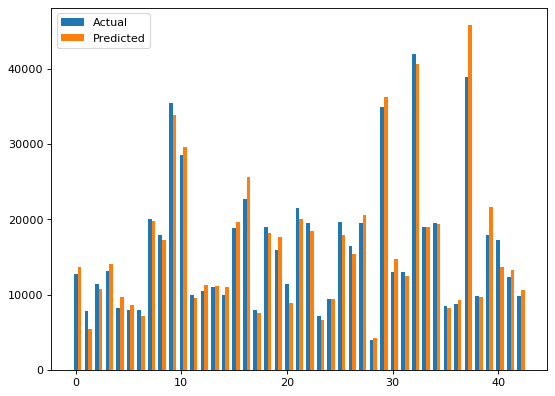

RMSE: 2266.8086021659024
4341


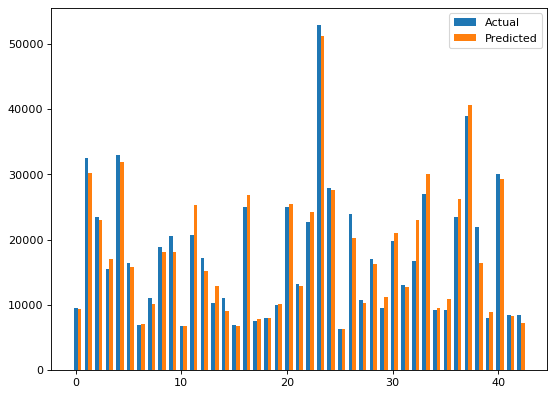

RMSE: 2373.370887283509
4341


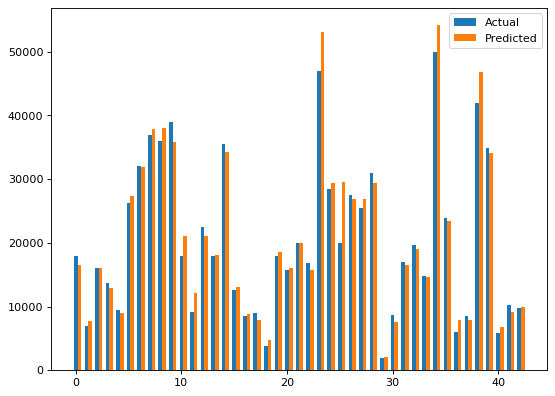

RMSE: 2397.824883077443
4341


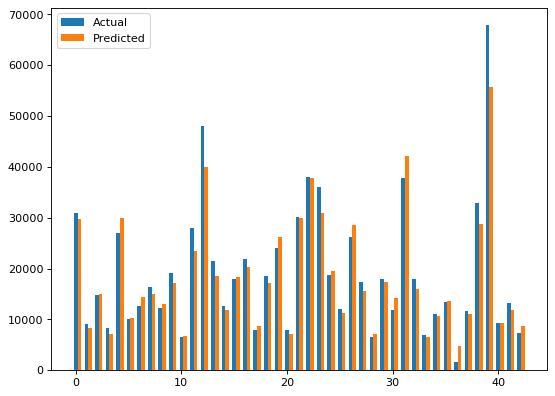

In [18]:
for dataset_train, dataset_test in splits_dataset:
    #print("\nTRAIN: [", train_index[0], " ... ", train_index[-1], "", "TEST:", test_index)

    y_train = dataset_train['price']
    y_test = dataset_test['price']
    X_train = dataset_train.drop(columns = 'price')
    X_test = dataset_test.drop(columns = 'price')
    
    arboles.set_params(**best_params)
    arboles.fit(X_train, y_train)

    y_pred = arboles.predict(X_test)

    print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

    print(int(y_test.shape[0] * 0.2))
    y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
    y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]

    bar_width = 0.35
    index = np.arange(0, y_test_plot.shape[0])
    actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
    pred = ax.bar(index + bar_width, y_pred_plot, width = bar_width, label = "Predicted")
    ax.legend()

    plt.show()

Degree = 1 & Alpha = 100
RMSE: 5182.261715772131
4341


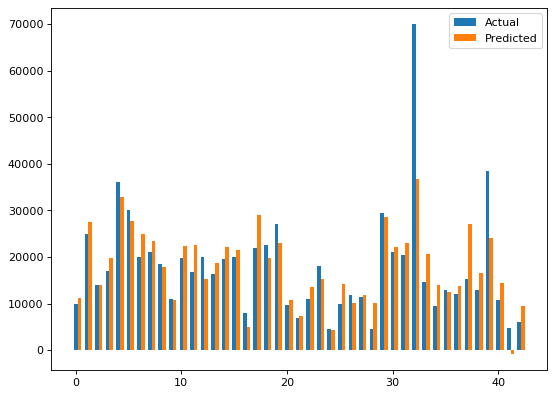

RMSE: 5130.393000513043
4341


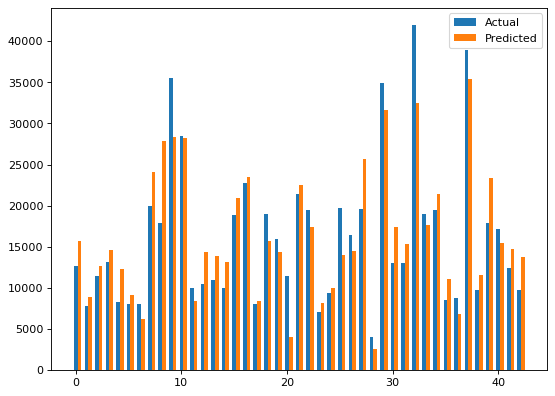

RMSE: 4981.609339076197
4341


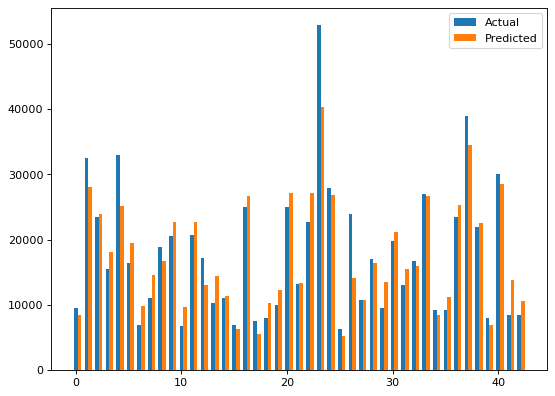

RMSE: 5035.546396232884
4341


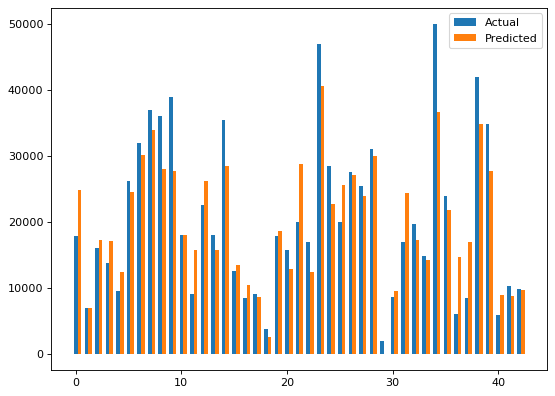

RMSE: 5141.615753905477
4341


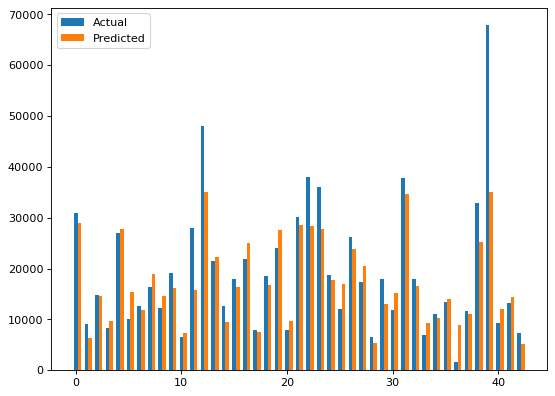

Degree = 1 & Alpha = 1000
RMSE: 6625.066050752644
4341


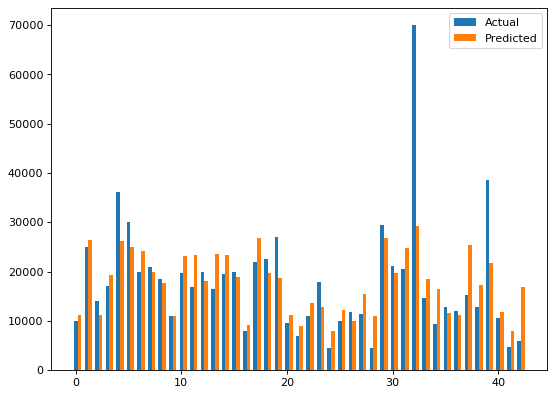

RMSE: 6596.067919127926
4341


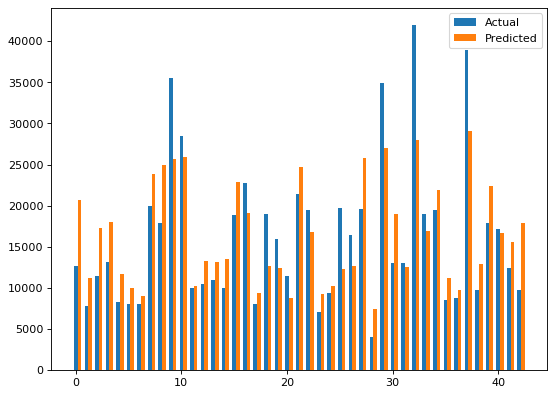

RMSE: 6445.077299040045
4341


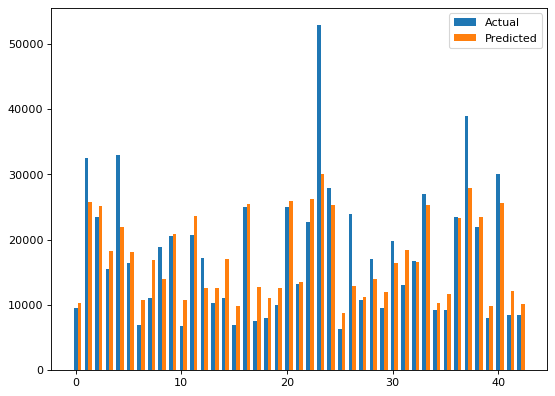

RMSE: 6496.922890475089
4341


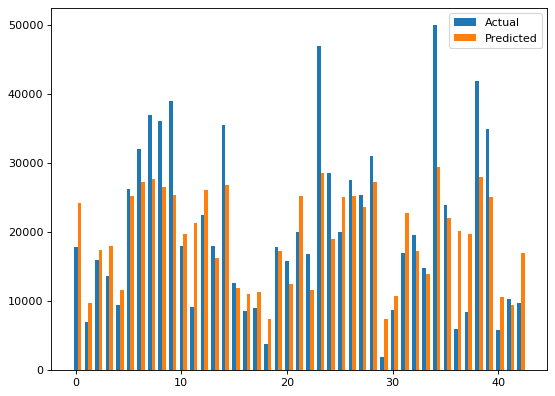

RMSE: 6569.530913733785
4341


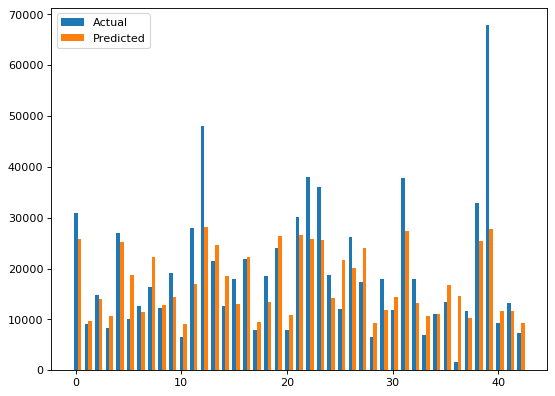

Degree = 2 & Alpha = 100
RMSE: 4486.6615001246
4341


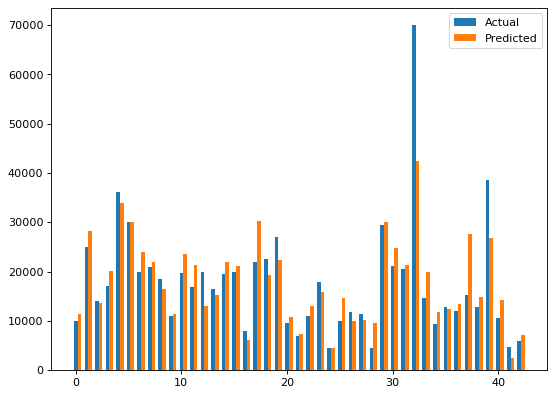

RMSE: 4459.953848485551
4341


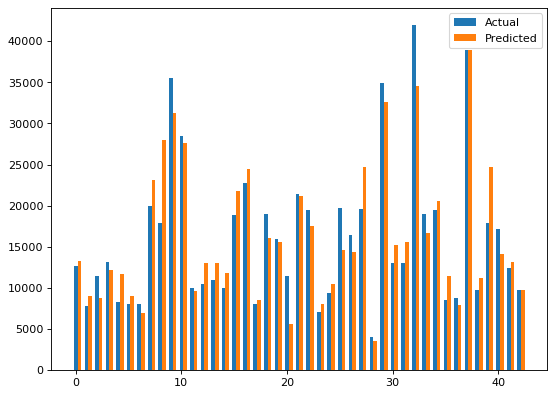

RMSE: 4280.708490253897
4341


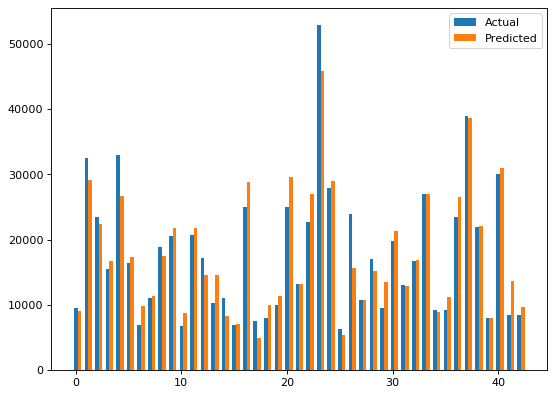

RMSE: 4335.796065104737
4341


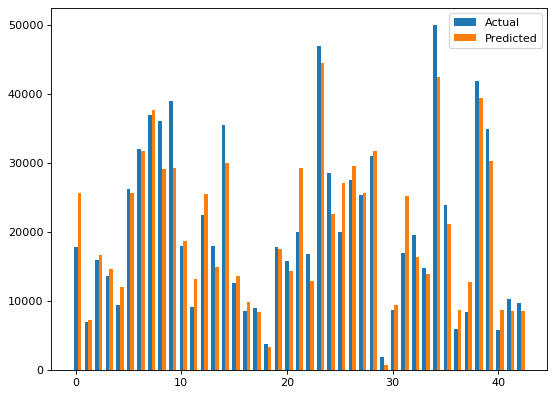

RMSE: 4461.026459381729
4341


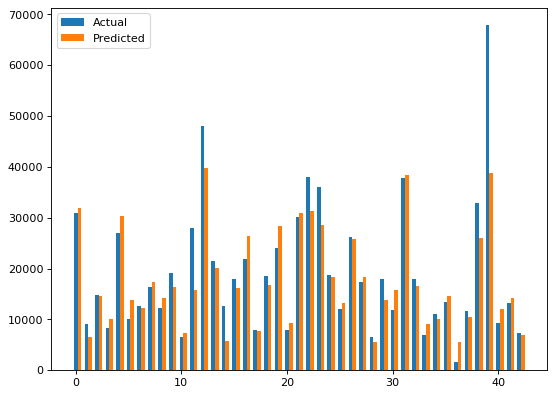

Degree = 2 & Alpha = 1000
RMSE: 5719.4110725352575
4341


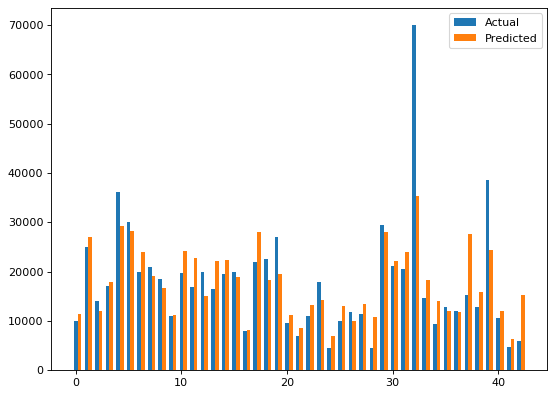

RMSE: 5691.925067186405
4341


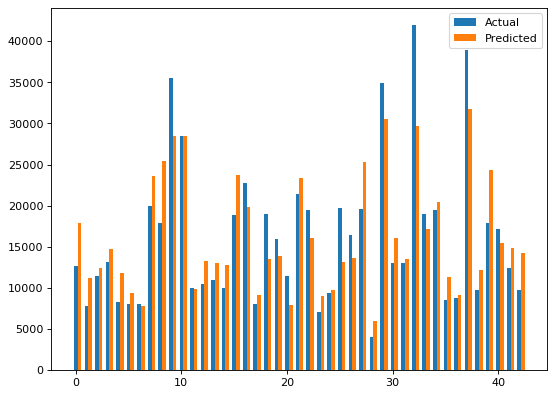

RMSE: 5534.672050017462
4341


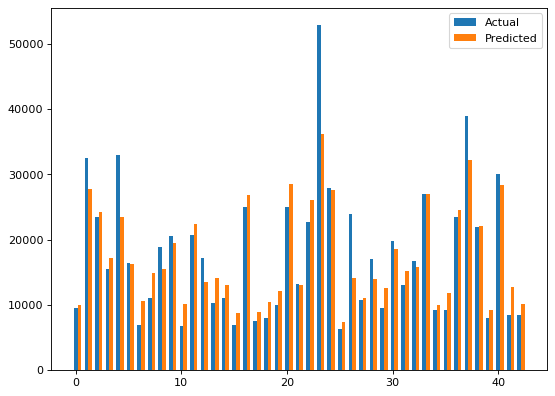

RMSE: 5604.630233053319
4341


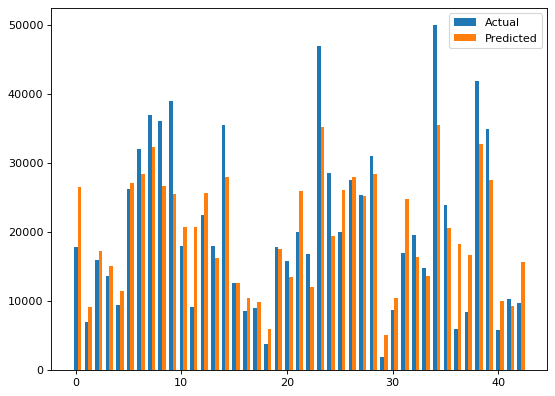

RMSE: 5686.676658692712
4341


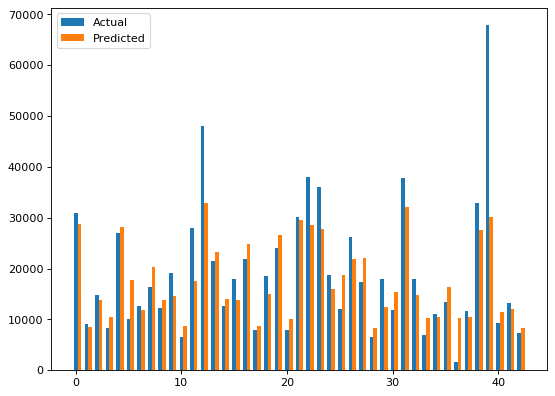

Degree = 3 & Alpha = 100
RMSE: 4196.703566707262
4341


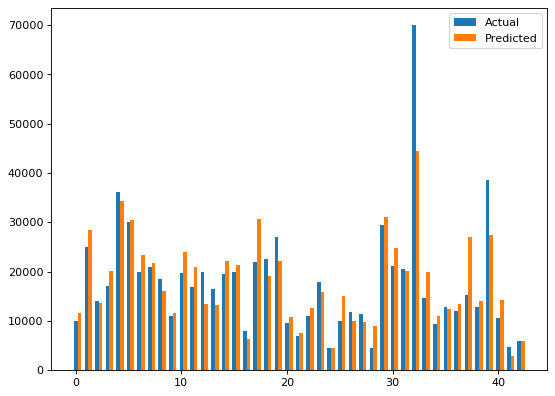

RMSE: 4192.6147964751335
4341


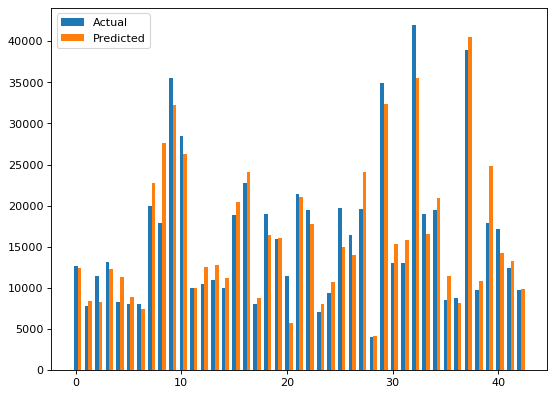

RMSE: 3988.3965501296143
4341


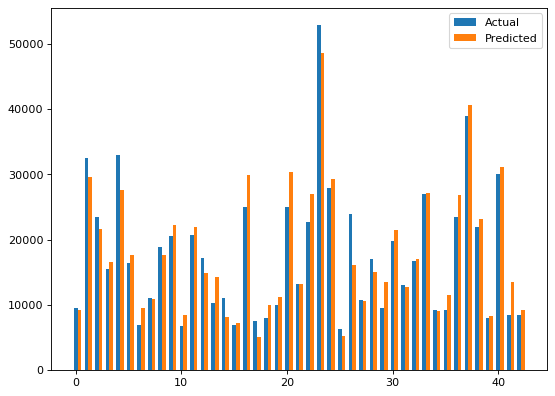

RMSE: 4045.9788512152113
4341


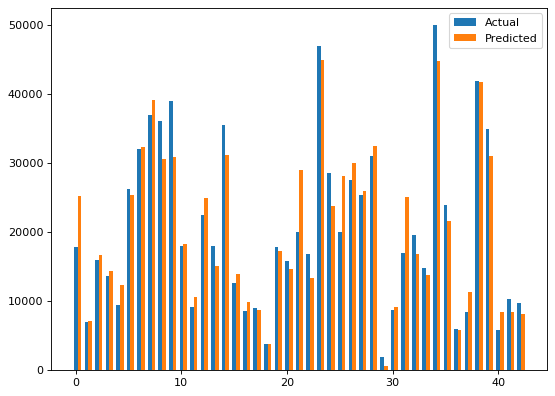

RMSE: 4179.918368382295
4341


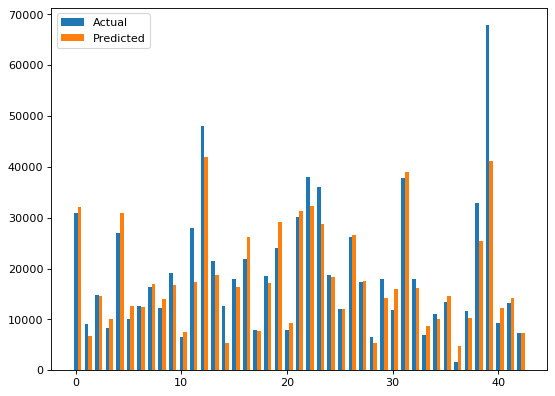

Degree = 3 & Alpha = 1000
RMSE: 5218.21607989001
4341


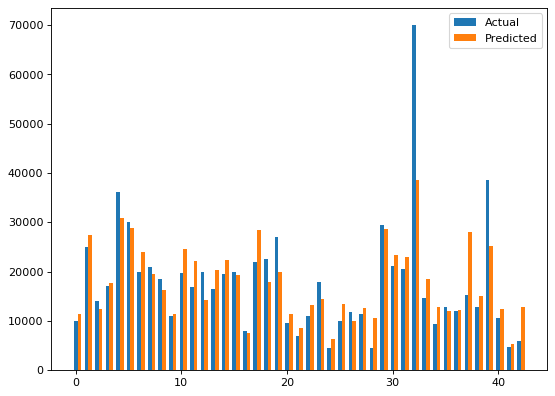

RMSE: 5199.820200303815
4341


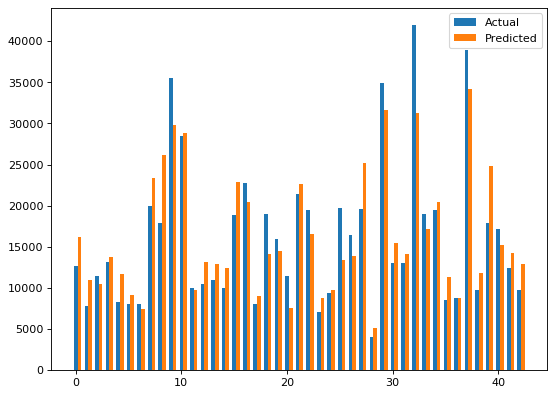

RMSE: 5028.048633175295
4341


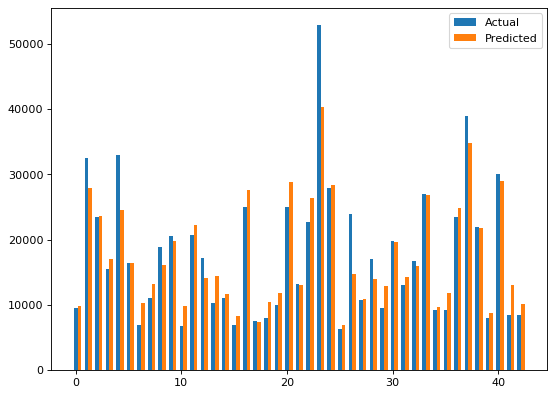

RMSE: 5100.507506278525
4341


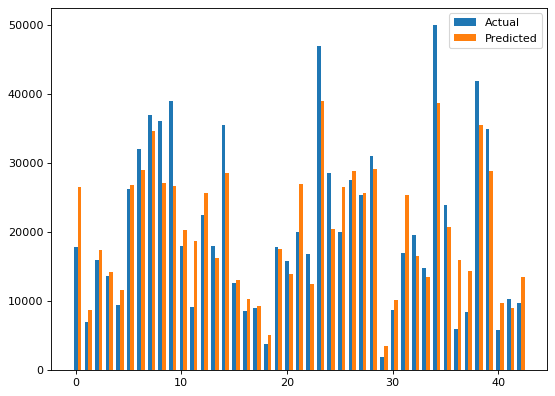

RMSE: 5198.296057875953
4341


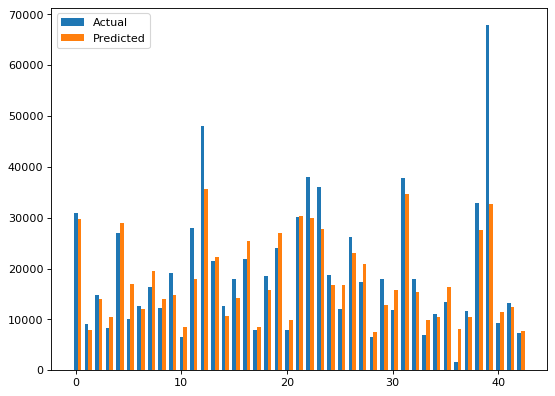

In [19]:
## REGRESIÓN POLINÓMICA

# Probamos inicialemente con grados 1 a 3 y alfa 0 - 100 - 1000 pero nos encontramos con desbordamiento para alfa = 0 con grado 2, 3 por lo que descartamos alfa = 0.
# No obstante para Degree = 1 & Alpha = 0 obtenemos los siguientes resultados:
# *   RMSE: 4752.610934687124
# *   RMSE: 4751.417876202925
# *   RMSE: 4558.413373796911
# *   RMSE: 4673.938648950828
# *   RMSE: 4891.033609496475

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('ridge', Ridge())])

for i, degree in enumerate([ 1, 2, 3]):
    for j, alpha in enumerate([ 100, 1000]):   

        print(f'Degree = {degree} & Alpha = {alpha}') 
        pipe.set_params(poly__degree=degree, ridge__alpha=alpha, ridge__fit_intercept=False)

        for dataset_train, dataset_test in splits_dataset:          

            y_train = dataset_train['price']
            y_test = dataset_test['price']
            X_train = dataset_train.drop(columns = 'price')
            X_test = dataset_test.drop(columns = 'price')          

            pipe.fit(X_train, y_train)            

            y_pred = pipe.predict(X_test)            

            print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))

            fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

            print(int(y_test.shape[0] * 0.2))

            y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
            y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]

            bar_width = 0.35
            index = np.arange(0, y_test_plot.shape[0])
            actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
            pred = ax.bar(index + bar_width, y_pred_plot, width = bar_width, label = "Predicted")

            ax.legend()

            plt.show()

RMSE: 4870.666116003394
4341


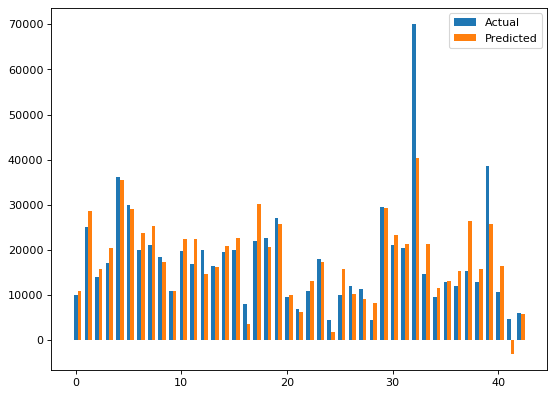

RMSE: 4788.165006320674
4341


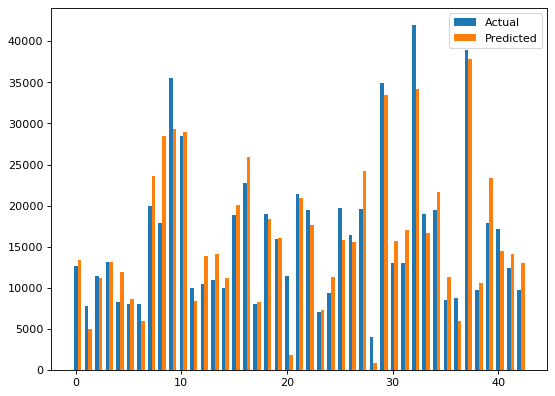

RMSE: 4634.619394771464
4341


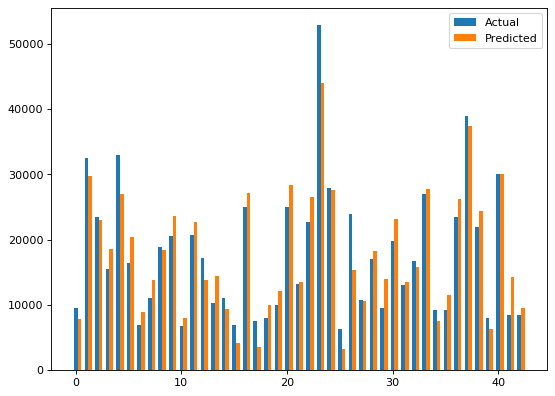

RMSE: 4687.761560097848
4341


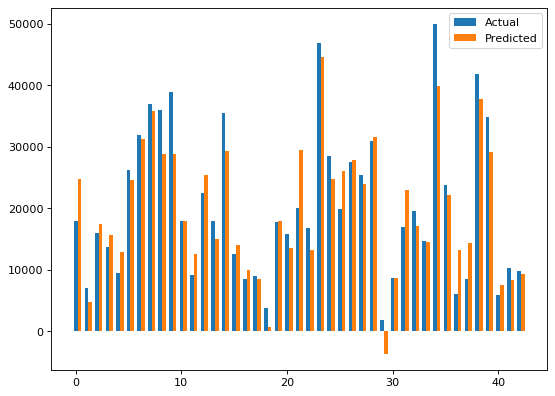

RMSE: 4831.46852251675
4341


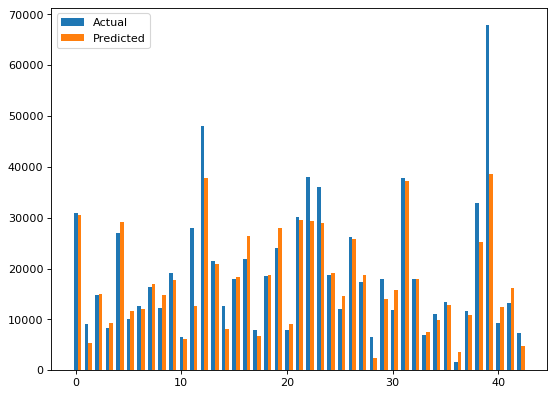

In [20]:
# Aplicación del SGDRegressor
# import warnings
# warnings.filterwarnings("ignore")

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=10000)  

for dataset_train, dataset_test in splits_dataset: 
    y_train = dataset_train['price']
    y_test = dataset_test['price']
    X_train = dataset_train.drop(columns = 'price')
    X_test = dataset_test.drop(columns = 'price')  

    sgd_reg.fit(X_train, y_train)    

    y_pred = sgd_reg.predict(X_test)    

    print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))



    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

    print(int(y_test.shape[0] * 0.2))

    y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
    y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]

    bar_width = 0.35
    index = np.arange(0, y_test_plot.shape[0])
    actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
    pred = ax.bar(index + bar_width, y_pred_plot, width = bar_width, label = "Predicted")
    ax.legend()

    plt.show()

In [21]:
# Red neuronal

tf.keras.backend.clear_session()

def generate_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(dataset.shape[1]-1,)),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

model = generate_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                375       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 786
Trainable params: 786
Non-trainable params: 0
__________________________________________________________

In [22]:
def plot_train_val(history):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    ax1.plot(history.history['loss'], label='loss (train)')
    ax1.plot(history.history['val_loss'], label='loss (val)')
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax2.plot(history.history['root_mean_squared_error'], label='accuracy (train)')
    ax2.plot(history.history['val_root_mean_squared_error'], label='accuracy (val)')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="lower right")
    ax1.grid()
    ax2.grid()
    plt.plot()

In [23]:
# Callbacks

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reduce_learning = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 5, min_lr = 0.00001)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = "model_checkpoint",
save_weights_only = True,
monitor = 'val_accuracy',
mode = 'max',
save_best_only = True
)

Epoch 1/50
2707/2707 [==============================] - 6s 2ms/step - loss: 126941976.0000 - root_mean_squared_error: 11266.8525 - val_loss: 53856584.0000 - val_root_mean_squared_error: 7338.7046
Epoch 2/50
2707/2707 [==============================] - 6s 2ms/step - loss: 60344344.0000 - root_mean_squared_error: 7768.1621 - val_loss: 46975296.0000 - val_root_mean_squared_error: 6853.8525
Epoch 3/50
2707/2707 [==============================] - 6s 2ms/step - loss: 52266796.0000 - root_mean_squared_error: 7229.5776 - val_loss: 37868628.0000 - val_root_mean_squared_error: 6153.7490
Epoch 4/50
2707/2707 [==============================] - 6s 2ms/step - loss: 42753828.0000 - root_mean_squared_error: 6538.6411 - val_loss: 28776200.0000 - val_root_mean_squared_error: 5364.3452
Epoch 5/50
2707/2707 [==============================] - 6s 2ms/step - loss: 35594984.0000 - root_mean_squared_error: 5966.1533 - val_loss: 23260598.0000 - val_root_mean_squared_error: 4822.9243
Epoch 6/50
2707/2707 [======

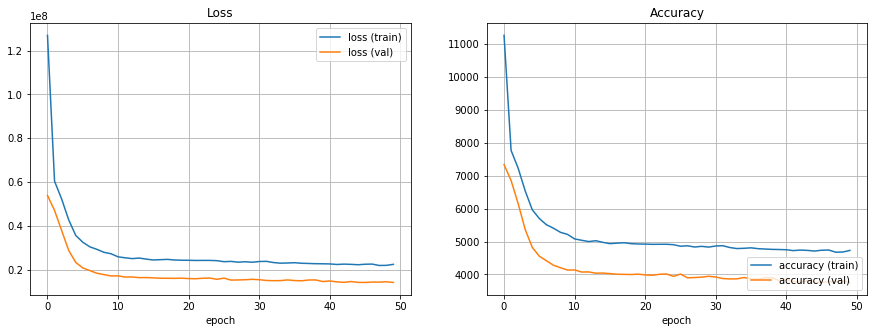

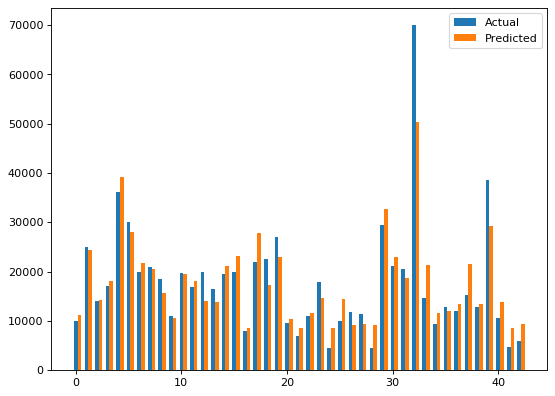

679/679 [==============================] - 1s 1ms/step - loss: 14116502.0000 - root_mean_squared_error: 3757.1934
[14116502.0, 3757.193359375]
Epoch 1/50
2707/2707 [==============================] - 7s 2ms/step - loss: 130858312.0000 - root_mean_squared_error: 11439.3320 - val_loss: 54364888.0000 - val_root_mean_squared_error: 7373.2549
Epoch 2/50
2707/2707 [==============================] - 6s 2ms/step - loss: 61367192.0000 - root_mean_squared_error: 7833.7217 - val_loss: 47771852.0000 - val_root_mean_squared_error: 6911.7183
Epoch 3/50
2707/2707 [==============================] - 6s 2ms/step - loss: 54621560.0000 - root_mean_squared_error: 7390.6401 - val_loss: 39752876.0000 - val_root_mean_squared_error: 6304.9883
Epoch 4/50
2707/2707 [==============================] - 6s 2ms/step - loss: 46866808.0000 - root_mean_squared_error: 6845.9336 - val_loss: 31261548.0000 - val_root_mean_squared_error: 5591.2026
Epoch 5/50
2707/2707 [==============================] - 5s 2ms/step - loss: 395

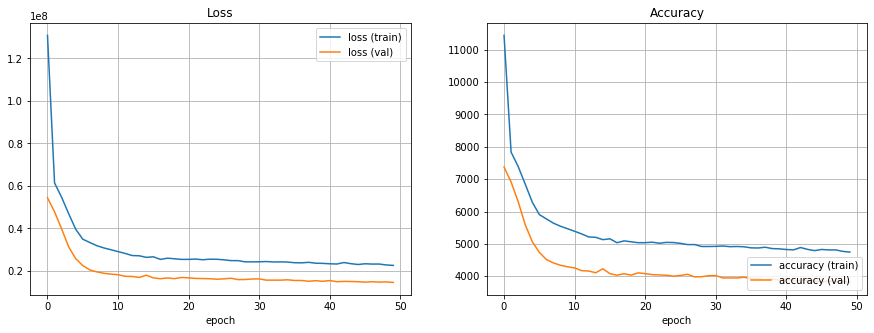

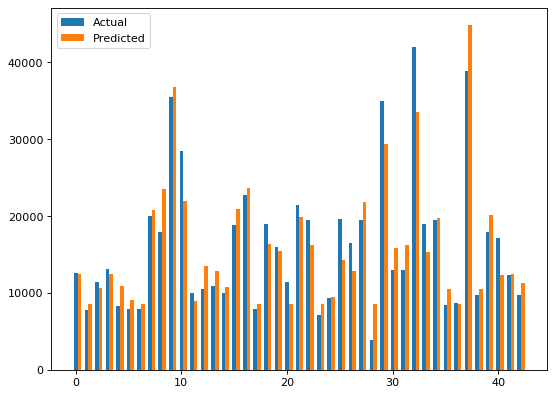

679/679 [==============================] - 1s 1ms/step - loss: 14511037.0000 - root_mean_squared_error: 3809.3354
[14511037.0, 3809.33544921875]
Epoch 1/50
2707/2707 [==============================] - 6s 2ms/step - loss: 121670520.0000 - root_mean_squared_error: 11030.4365 - val_loss: 51118876.0000 - val_root_mean_squared_error: 7149.7466
Epoch 2/50
2707/2707 [==============================] - 5s 2ms/step - loss: 61248164.0000 - root_mean_squared_error: 7826.1206 - val_loss: 43084796.0000 - val_root_mean_squared_error: 6563.9009
Epoch 3/50
2707/2707 [==============================] - 5s 2ms/step - loss: 52211964.0000 - root_mean_squared_error: 7225.7847 - val_loss: 33992644.0000 - val_root_mean_squared_error: 5830.3213
Epoch 4/50
2707/2707 [==============================] - 5s 2ms/step - loss: 42488916.0000 - root_mean_squared_error: 6518.3521 - val_loss: 25604310.0000 - val_root_mean_squared_error: 5060.0703
Epoch 5/50
2707/2707 [==============================] - 5s 2ms/step - loss: 3

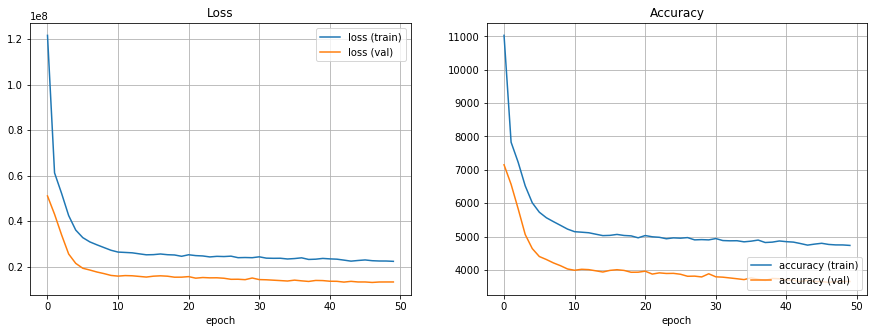

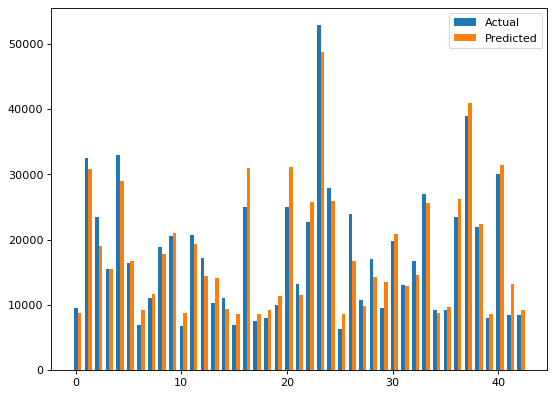

679/679 [==============================] - 1s 1ms/step - loss: 13332766.0000 - root_mean_squared_error: 3651.4060
[13332766.0, 3651.406005859375]
Epoch 1/50
2707/2707 [==============================] - 6s 2ms/step - loss: 133485008.0000 - root_mean_squared_error: 11553.5713 - val_loss: 51881380.0000 - val_root_mean_squared_error: 7202.8730
Epoch 2/50
2707/2707 [==============================] - 6s 2ms/step - loss: 60657992.0000 - root_mean_squared_error: 7788.3242 - val_loss: 43856496.0000 - val_root_mean_squared_error: 6622.4238
Epoch 3/50
2707/2707 [==============================] - 5s 2ms/step - loss: 51718764.0000 - root_mean_squared_error: 7191.5757 - val_loss: 34107504.0000 - val_root_mean_squared_error: 5840.1631
Epoch 4/50
2707/2707 [==============================] - 5s 2ms/step - loss: 43707216.0000 - root_mean_squared_error: 6611.1436 - val_loss: 27829762.0000 - val_root_mean_squared_error: 5275.3921
Epoch 5/50
2707/2707 [==============================] - 5s 2ms/step - loss: 

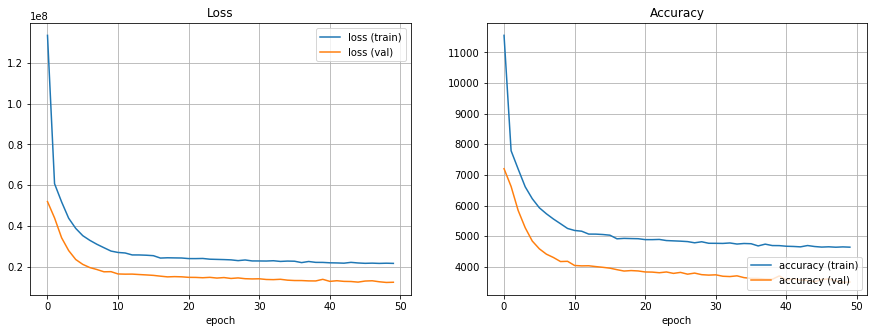

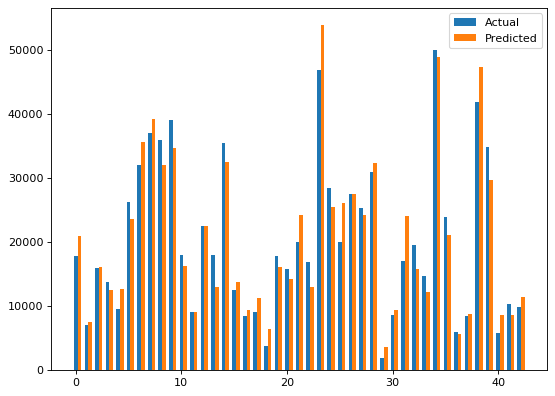

679/679 [==============================] - 1s 1ms/step - loss: 12283537.0000 - root_mean_squared_error: 3504.7878
[12283537.0, 3504.787841796875]
Epoch 1/50
2707/2707 [==============================] - 6s 2ms/step - loss: 131772848.0000 - root_mean_squared_error: 11479.2354 - val_loss: 52176376.0000 - val_root_mean_squared_error: 7223.3218
Epoch 2/50
2707/2707 [==============================] - 6s 2ms/step - loss: 59602608.0000 - root_mean_squared_error: 7720.2725 - val_loss: 43534476.0000 - val_root_mean_squared_error: 6598.0659
Epoch 3/50
2707/2707 [==============================] - 6s 2ms/step - loss: 49781780.0000 - root_mean_squared_error: 7055.6206 - val_loss: 33296778.0000 - val_root_mean_squared_error: 5770.3359
Epoch 4/50
2707/2707 [==============================] - 5s 2ms/step - loss: 42342140.0000 - root_mean_squared_error: 6507.0840 - val_loss: 28457644.0000 - val_root_mean_squared_error: 5334.5708
Epoch 5/50
2707/2707 [==============================] - 6s 2ms/step - loss: 

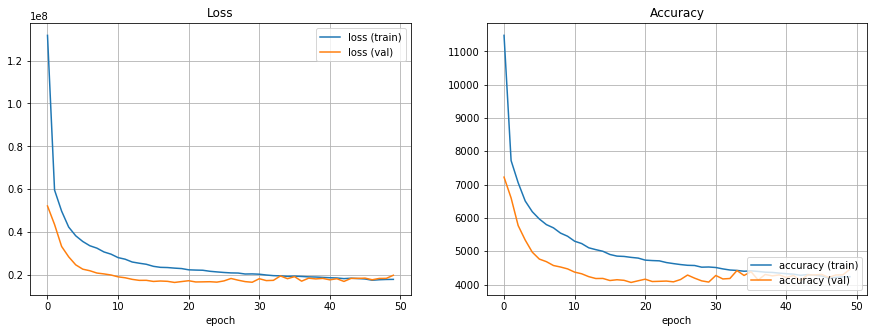

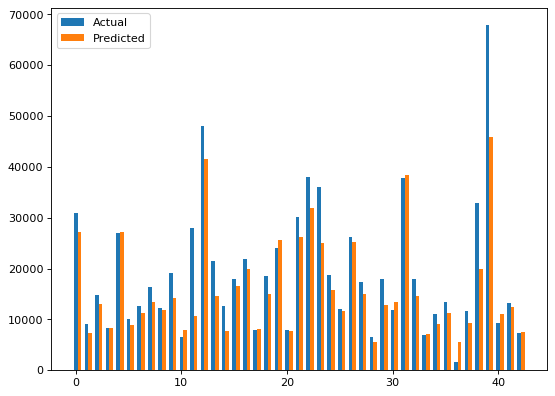

679/679 [==============================] - 1s 1ms/step - loss: 19862826.0000 - root_mean_squared_error: 4456.7729
[19862826.0, 4456.77294921875]


In [48]:
for dataset_train, dataset_test in splits_dataset:
    #print("\nTRAIN: [", train_index[0], " ... ", train_index[-1], "", "TEST:", test_index)
    
    y_train = dataset_train['price']
    y_test = dataset_test['price']
    X_train = dataset_train.drop(columns = 'price')
    X_test = dataset_test.drop(columns = 'price')

    with tf.device('/device:GPU:1'):
        tf.keras.backend.clear_session()
        model = generate_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.mean_squared_error,
            metrics=[
                tf.keras.metrics.RootMeanSquaredError()
            ]
        )
        history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data = (X_test, y_test))
    
    plot_train_val(history)
    
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    print(int(y_test.shape[0] * 0.2))
    y_test_plot = y_test.head(int(y_test.shape[0] * 0.002))
    y_pred_plot = y_pred[0:int(y_test.shape[0] * 0.002)]
    bar_width = 0.35
    index = np.arange(0, y_test_plot.shape[0])
    actual = ax.bar(index, y_test_plot, width = bar_width, label = "Actual")
    pred = ax.bar(index + bar_width, np.matrix.flatten(y_pred_plot), width = bar_width, label = "Predicted")
    ax.legend()
    plt.show()


    print(model.evaluate(X_test, y_test))